In [47]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchvision import datasets, transforms
from  PIL import Image

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**1. Завантаження та попередня обробка зображень для CNN:**
  * Завантажте набір даних (наприклад, CIFAR-10, MNIST, або інший публічний датасет для зображень). та розділіть його на навчальну та тестову вибірки.
  * Нормалізуйте значення пікселів до діапазону [0, 1].
  * Якщо необхідно, виконайте перетворення даних, такі як обрізання, повороти або віддзеркалення для збільшення кількості навчальних зображень (augmentation).

In [49]:
# Навчальний датасет augmentation
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomRotation(10),
                                      transforms.ToTensor()
                                      ])

# Навчальний датасет без augmentation
transform_test = transforms.Compose([transforms.ToTensor()
                                     ])

# Датасет cifar-10
train_dataset = datasets.CIFAR10(root='./data',
                                 train = True,
                                 download = True,
                                 transform = transform_train)
test_dataset = datasets.CIFAR10(root='./data',
                                train = False,
                                download = True,
                                transform = transform_test)

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)
class_names = train_dataset.classes

Files already downloaded and verified
Files already downloaded and verified


In [50]:
image, label = train_dataset[1]

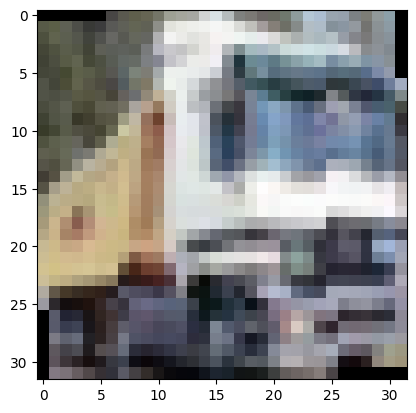

In [51]:
#Після трансформації оригінального зображення
single_img = np.array(image)
single_img_reshaped = np.transpose(np.reshape(single_img,(3, 32,32)), (1,2,0))
plt.imshow(single_img_reshaped)

In [52]:
#Час виконання
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


# Метрика правильності
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

**2 Створення архітектури CNN:**
  * Побудуйте просту CNN з кількох згорткових шарів (Conv2D) з функціями активації ReLU.
  * Додайте шари підсемплювання (MaxPooling2D) після згорткових шарів для зменшення розміру.
  * Розгорніть результати згорткових шарів (Flatten) і додайте один або більше повнозв’язних шарів (Dense).
  * Вихідний шар із softmax для класифікації зображень на категорії.

In [53]:
#Створюємо класс CNN моделі
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_layers(x)
        x = self.classifier(x)

        return x

In [54]:
torch.manual_seed(42)
model = CNNModel()

#Ініціалізація функцію втрати та оптимізатор(Adam)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)

In [55]:
model

CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [56]:
#from content.helper_functions import accuracy_fn
from tqdm.auto import tqdm
torch.manual_seed(42)
train_time_start_on_cpu = timer()


# Тренування моделі
epochs = 10
loss_train_all = []
loss_test_all = []
acc_train_all = []
acc_test_all = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    model.train()

    #Тренування
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(train_loader):

      optimizer.zero_grad()

      # Прямий прохід
      y_logits = model(X)
      y_pred = torch.softmax(y_logits, dim = 1)

      # Дивимося втрати
      loss = loss_fn(y_logits, y)
      train_loss += loss

      # Визначаємо точність
      train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))


      # Зворотній прохід та оптимізація
      loss.backward()
      optimizer.step()

      #Результат
      if batch % 400 == 0:
          print(f'Looked at {batch * len(X)}/{len(train_loader.dataset)} samples')

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    ### Тестування

    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in test_loader:

            # Прямий прохід
            #test_pred = model(X)
            test_logits = model(X)
            test_pred = torch.softmax(test_logits, dim = 1)

            # Дивимося втрати
            test_loss += loss_fn(test_logits, y)

            # Визначаємо точність
            test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim=1))

        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

    ## Результат
    print(f"\nTrain loss: {train_loss:.5f} Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

    loss_train_all.append(train_loss)
    loss_test_all.append(test_loss)
    acc_train_all.append(train_acc)
    acc_test_all.append(test_acc)

# Рахуємо витрачений час
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu,
                                           end = train_time_end_on_cpu,
                                           device = str(next(model.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train loss: 1.44813 Train acc: 47.30% | Test loss: 1.16348, Test acc: 58.26%

Epoch: 1
-------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train loss: 1.10996 Train acc: 60.44% | Test loss: 0.99834, Test acc: 64.93%

Epoch: 2
-------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train loss: 0.99518 Train acc: 64.89% | Test loss: 0.95837, Test acc: 65.48%

Epoch: 3
-------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train loss: 0.92795 Train acc: 67.28% | Test loss: 0.89583, Test acc: 68.92%

Epoch: 4
-------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples

Train loss: 0.8751

**Графік втрати та точності під час навчання**

In [57]:
scalar_loss_train_list = [t.item() for t in loss_train_all]
scalar_loss_test_list = [t.item() for t in loss_test_all]

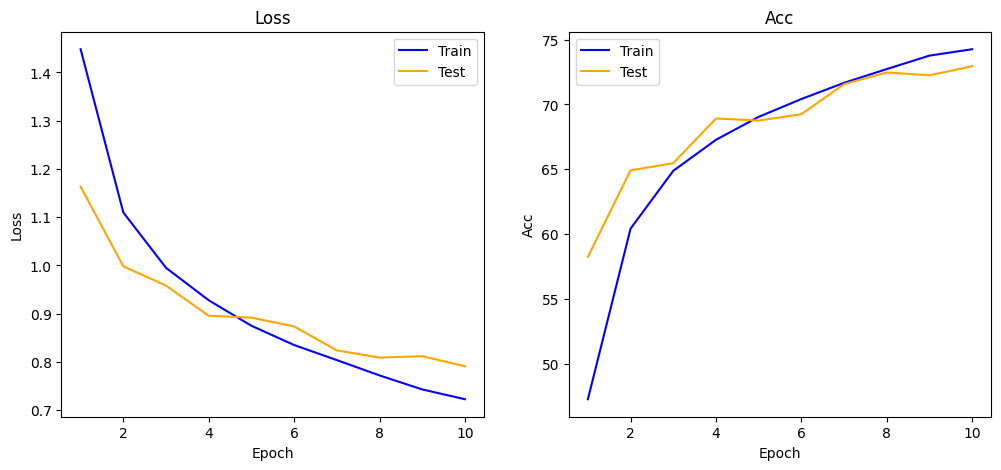

In [58]:
epochs = range(1, 10+1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, scalar_loss_train_list, 'blue', label='Train')
plt.plot(epochs, scalar_loss_test_list, 'orange', label='Test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Acc
plt.subplot(1,2,2)
plt.plot(epochs, acc_train_all, 'blue', label='Train')
plt.plot(epochs, acc_test_all, 'orange', label='Test')
plt.title('Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()

plt.show()

**Оцінка моделі**

In [59]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):

    loss, acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            # Прямий прохід
            test_logits = model(X)
            test_pred = torch.softmax(test_logits, dim = 1)

            # Дивимося втрати
            loss += loss_fn(test_logits, y)

            # Визначаємо точність
            acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Рахуємо точність та витрати на тестовому наборі
model_results = eval_model(model = model,
                           data_loader = test_loader,
                           loss_fn = loss_fn,
                           accuracy_fn = accuracy_fn,
                           device = device
)

model_results

{'model_name': 'CNNModel',
 'model_loss': 0.791183590888977,
 'model_acc': 72.94329073482429}

**Confusion matrix**

In [63]:
from tqdm.auto import tqdm

y_preds = []

model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc = "Making predictions"):

    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim = 1).argmax(dim = 1)

    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

mlxtend version: 0.23.3


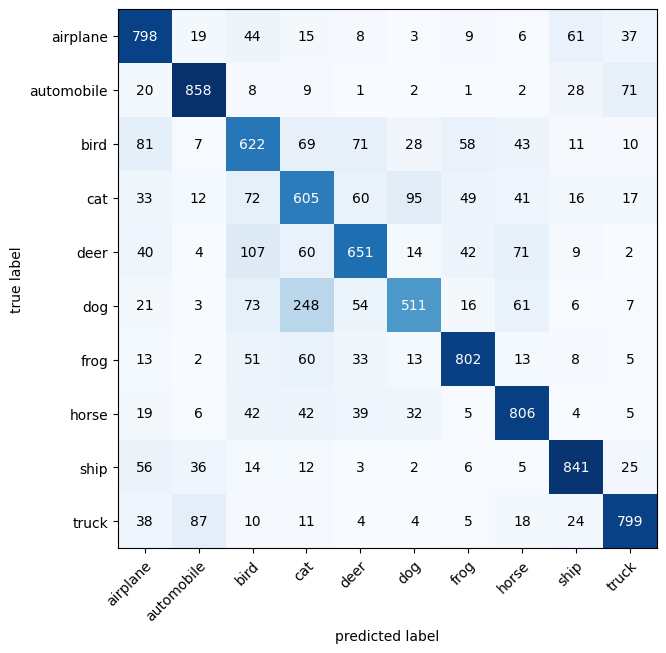

In [65]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")


from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

targets_tensor = torch.tensor(test_dataset.targets) if isinstance(test_dataset.targets, list) else test_dataset.targets


confmat = ConfusionMatrix(num_classes = len(class_names), task = 'multiclass')
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = targets_tensor)

fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                                class_names = class_names,
                                figsize=(10, 7)
);